---
**Dataset:** *Coral reef global bleaching*


**Objective:** *Predict reef bleaching*

**Author:** *Danylo Zemskyi, Omari March*

**Date:** *15/12/2025*

---

## 1. Introduction

### 1.1 Problem Statement

* Description of the task:Bleaching prediction for Coral Reef Global Bleaching dataset.
* Target variable: This problem is about predicting how much coral bleaching occurs (measured as Percent Bleaching) based on environmental and physical factors like water depth, temperature, distance from shore, exposure, turbidity, and cyclone frequency (Regression problem).
* Topic relevance: Coral reefs play a vital role in marine ecosystem health. Coral reefs are able to support diverse ecosystems, filter the water, and create oxygen when they have clean, clear, and cool water to support them. Also, they protect shorelines by reducing the impact from waves, storms, and floods. This helps prevent loss of life, property damage, and erosion. When reefs are damaged or destroyed, coastal communities can suffer increased damage from severe storms, and even normal wave action. Bleached corals continue to live, but they are more vulnerable to disease and starvation.

### 1.2 Dataset Overview

* Source of the dataset: https://www.kaggle.com/datasets/mehrdat/coral-reef-global-bleaching
* Number of samples and features: The dataset consists of 2 csv files, which have 18 and 62 Features, and 41361 rows each. Csv file with 62 features provides a lot of redundant metrics that can be derived with formulas. Both files can be merged by Sample_ID column
* Feature types (numerical, categorical, target)


## 2. Experimental Setup

### 2.1 Libraries

Used libs
numpy
pandas

matplotlib
seaborn
os

sklearn
statsmodels
scipy

xgboost
tensorflow.keras

### 2.2 Evaluation Metrics

* Metrics used: R2 and MAE
* Justification: MAE is preferred in tasks involving skewed or outlier-prone data because it provides a robust, scale-consistent measure of average model error without disproportionately penalizing large deviations.
	As the baseline model mean predictor was chosen, which can give a sense what is the minimal mean absolute error model has to archive to be better than a simple mean model (MAEbaseline = 11.29).
	R2 provides an interpretable measure of overall model fit and how well the model captures data patterns relative to a naive mean-based predictor, which is picked as baseline performance.

### 2.3 Dataset split

* Split method used: train-test split(TTS)
* TTS chosen over k-fold cross-validation as the dataset is sufficiently large to minimize overfitting risks associated with TTS, while significantly reducing computational cost by requiring only a single model training instead of multiple iterations.




In [92]:
from keras.src.metrics.correlation_metrics import pearson_correlation
from scipy.stats import spearmanr
from tensorflow.python.ops.metrics_impl import root_mean_squared_error

"""Data manipulations libs"""
import numpy as np
import pandas as pd

"""Plotting libs"""
import matplotlib.pyplot as plt
import seaborn as sns
import os

"""Models evaluations imports"""
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

"""Data preprocessing imports"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox


"""Dataset stats imports"""
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor

"""Models that were used imports"""
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, Dropout, ReLU, Add
)
from tensorflow.keras.callbacks import EarlyStopping

## 3. Baseline Model


### 3.1 Baseline Definition

Since this the task involves regression for Percent_Bleaching prediction, the baseline performance can be assessed using simple models such as the mean predictor or median predictor, which always predict the average or median bleaching percentage across the dataset. That will provide us with a reference level of performance to compare more complex models against.

### 3.2 Baseline Results

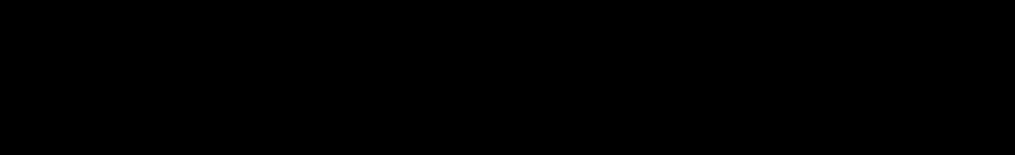

In [102]:
import pandas as pd
import os

path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df  = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df.dropna(inplace=True)

df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4

In [79]:
# Target value
y = df['Percent_Bleaching'].to_list()

# Mean prediction
y_median = np.median(y)
y_mean = np.mean(y)

y_pred_median = np.full(len(y), y_median)
y_pred_mean = np.full(len(y), y_mean)

# Metrics Median
mae_median = mean_absolute_error(y, y_pred_median)
rmse_median = root_mean_squared_error(y, y_pred_median)
r2_median = r2_score(y, y_pred_median)

print("Median Baseline Results:")
print(f"MAE: {mae_median:.4f}")
print(f"RMSE: {rmse_median:.4f}")
print(f"R: {r2_median:.4f}")

# Metrics Mean
mae_mean = mean_absolute_error(y, y_pred_mean)
rmse_mean = root_mean_squared_error(y, y_pred_mean)
r2_mean = r2_score(y, y_pred_mean)

print("\nMean Baseline Results:")
print(f"MAE: {mae_mean:.4f}")
print(f"RMSE: {rmse_mean:.4f}")
print(f"R: {r2_mean:.4f}")



Median Baseline Results:
MAE: 8.0678
RMSE: 19.8756
R: -0.1973

Mean Baseline Results:
MAE: 11.2953
RMSE: 18.1646
R: 0.0000


In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = [col for col in df.columns if col not in num_cols]

target_value_col = "Percent_Bleaching"

## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Distribution

Histogram shows that target value has a lot of outliers and extremely skewed around 0%, which implies that Percent_Bleaching values has to be scaled to mitigate impact of imbalance distribution and normalized. Such categorical data as Ocean_Name, Country_Name, Exposure, and Realm_Name has to be encoded with OneHotEncoder to make it feedable to the models.

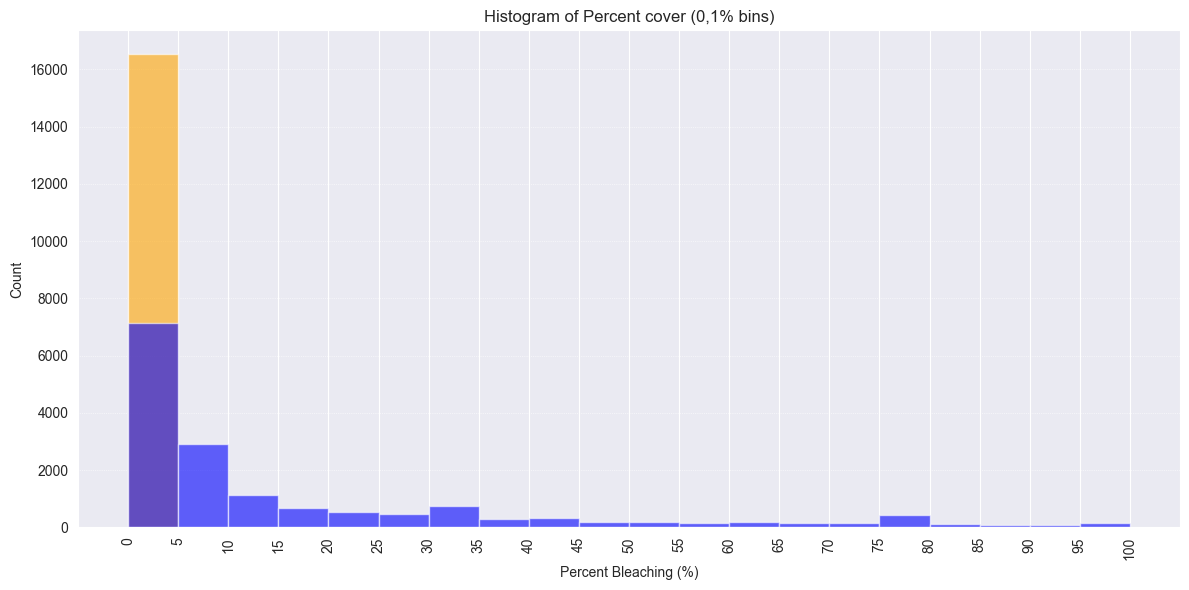

In [110]:

high_bleaching = df[target_value_col] > 0  # 50% threshold
low_bleaching = df[target_value_col] <= 0

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5
labels = [f"{b}–{b+5}%" for b in bins[:-1]]



plt.figure(figsize=(12, 6))
plt.hist(
    df.loc[low_bleaching, target_value_col],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Low / Not Bleaching (=0%)"
)
plt.hist(
    df.loc[high_bleaching, target_value_col],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Bleaching (>0%)"
)
plt.xticks(bins)
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent cover (0,1% bins)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



### 4.2 Feature Distribution and Skewness

The majority of numerical features in the dataset exhibit pronounced skewness, with several key variables showing strong right-skew (e.g., Distance_to_Shore, Turbidity, Percent_Bleaching) and others displaying left-skewed distributions (e.g., ClimSST, Temperature_Mean, TSA), indicating non-normal feature distributions and further motivating the use of transformation and non-linear modeling approaches.


In [132]:

def get_skewness(df, num_cols):
    skewness_results = {}

    for col in num_cols:
        clean_data = df[col].dropna()
        if len(clean_data) > 0:
            skew_val = skew(clean_data)
            skewness_results[col] = {
                'skewness': skew_val,
                'skew_type': 'Right (Positive)' if skew_val > 0.5 else 'Left (Negative)' if skew_val < -0.5 else 'Approximately Symmetric',

            }

    skewness_df = pd.DataFrame(skewness_results).T
    skewness_df = skewness_df.sort_values('skewness', key=abs, ascending=False)
    print(skewness_df[:-1])
    return skewness_results


skewness_results = get_skewness(df, num_cols)

                    skewness         skew_type
Distance_to_Shore    8.27198  Right (Positive)
Turbidity            3.66025  Right (Positive)
ClimSST             -1.78877   Left (Negative)
Temperature_Mean    -1.14005   Left (Negative)
TSA                 -0.99701   Left (Negative)
Cyclone_Frequency    0.96937  Right (Positive)
Temperature_Maximum  0.91738  Right (Positive)
Depth_m              0.52139  Right (Positive)


{'Cyclone_Frequency': {'skewness': np.float64(0.9693687565678295),
  'skew_type': 'Right (Positive)'},
 'Depth_m': {'skewness': np.float64(0.5213921073477537),
  'skew_type': 'Right (Positive)'},
 'ClimSST': {'skewness': np.float64(-1.788769174624633),
  'skew_type': 'Left (Negative)'},
 'Distance_to_Shore': {'skewness': np.float64(8.271979557600973),
  'skew_type': 'Right (Positive)'},
 'Turbidity': {'skewness': np.float64(3.66024937888588),
  'skew_type': 'Right (Positive)'},
 'Temperature_Maximum': {'skewness': np.float64(0.9173807143350157),
  'skew_type': 'Right (Positive)'},
 'SSTA': {'skewness': np.float64(0.007283586741844499),
  'skew_type': 'Approximately Symmetric'},
 'TSA': {'skewness': np.float64(-0.9970115561821852),
  'skew_type': 'Left (Negative)'},
 'Temperature_Mean': {'skewness': np.float64(-1.140050342683623),
  'skew_type': 'Left (Negative)'}}

### 4.3 Feature Relationships

The Pearson correlation matrix shows generally weak linear relationships among the environmental variables and between predictors and the target variable (Percent_Bleaching). Most correlation coefficients are close to zero, indicating limited linear dependence.

<Axes: >

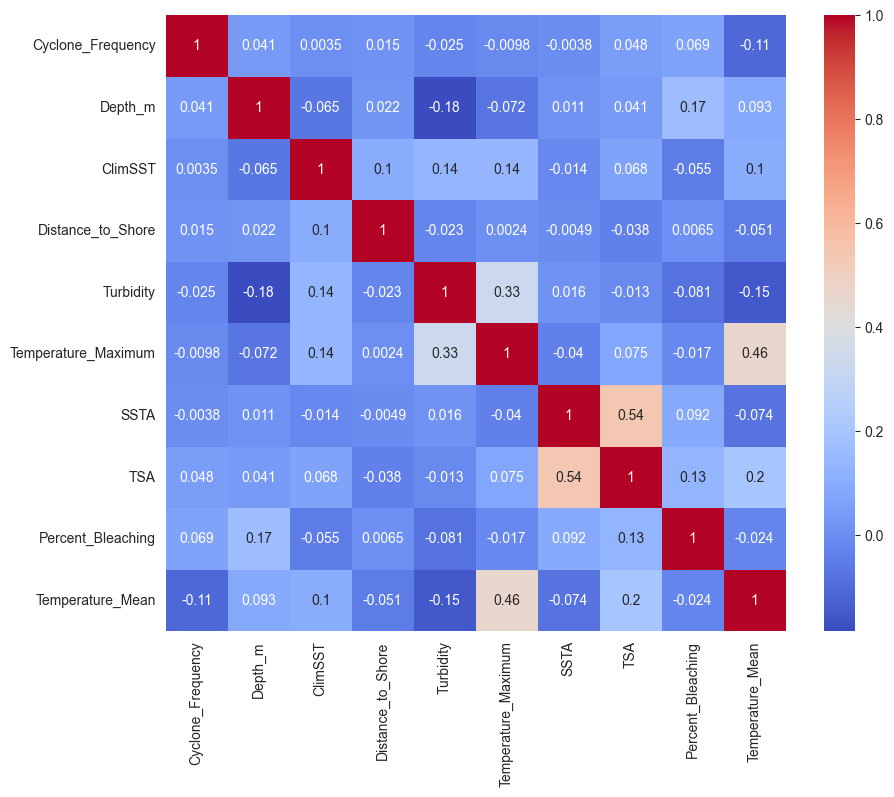

In [83]:

df_numeric = df[num_cols]

pearson_corr_matrix = df_numeric.corr(method="pearson")

features = pearson_corr_matrix.index

plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm")

The Spearman correlation matrix reveals stronger monotonic relationships than those observed with Pearson correlation, indicating that several variables are related in a non-linear but monotonic manner.

<Axes: >

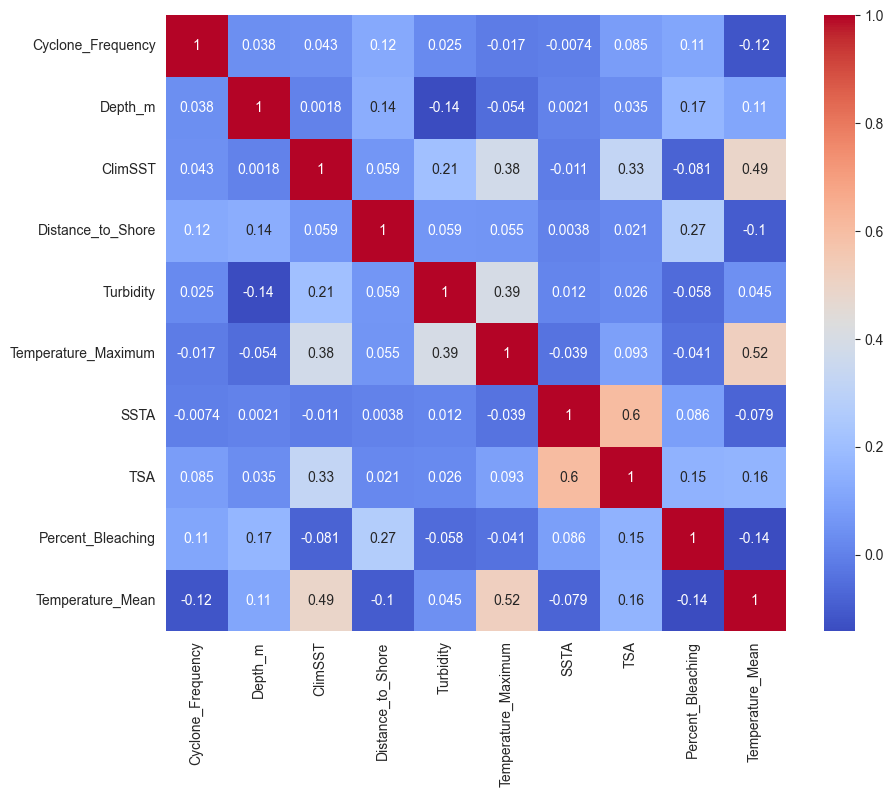

In [84]:
spearman_corr_matrix = df_numeric.corr(method="spearman")
features = spearman_corr_matrix.index

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm")

The VIF analysis reveals severe multicollinearity among temperature-related variables (Temperature_Mean and ClimSST), confirming strong feature redundancy and motivating the use  non-linear models that are less sensitive to collinearity.

In [85]:
vif_data = pd.DataFrame()
vif_data["features"] = num_cols

vif_data["vif"] = [variance_inflation_factor(df_numeric.values, i)
                   for i in range(len(num_cols))]

vif_data

,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


Overall, the dataset exhibits non-linear relationships, significant feature redundancy, skewed feature distributions, and interaction effects, pushing the use of scaled non-linear models and ensemble methods for robust prediction.


## 5. Data Preprocessing

Before selecting feature set it is better to see the effect of categorical data on DecisionTreeRegressor(), since they carry a lot of environmental data

In [142]:
def test_model(model, X_test, y_test, plot_title = ""):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"R2 score for {plot_title}: {r2}")
    print(f"MAE score for {plot_title}: {mae}")

    residuals = y_test - y_pred

    # Plot residuals vs predicted
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {plot_title}")
    plt.show()


In [131]:
path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df_large = df.drop(columns=['Sample_ID', 'Percent_Cover', 'Date_Year']) #Percent_Cover has 30% of its row NA, so it significantly cuts dataset
df_large.dropna(inplace=True)

df_small = df.dropna(inplace=True)
df_small = df.drop(columns=['Sample_ID', 'Date_Year'])

df_large.info()
df_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Ocean_Name           32714 non-null  object 
 4   Country_Name         32714 non-null  object 
 5   Distance_to_Shore    32714 non-null  float64
 6   Exposure             32714 non-null  object 
 7   Turbidity            32714 non-null  float64
 8   Bleaching_Level      32714 non-null  object 
 9   Temperature_Maximum  32714 non-null  float64
 10  SSTA                 32714 non-null  float64
 11  TSA                  32714 non-null  float64
 12  Percent_Bleaching    32714 non-null  float64
 13  Temperature_Mean     32714 non-null  float64
 14  Realm_Name           32714 non-null  object 
dtypes: float64(10), object(5)
memory usage: 4


### 5.1 Handle N/A

During exploratory analysis, it was observed that the **Percent_Cover** feature contains a substantial proportion of missing values (approximately 30%). Rather than applying imputation, which could introduce additional assumptions and bias, the analysis was structured around two variations of the dataset: one including **Percent_Cover** using only samples where it is available, and another excluding the feature entirely to retain the full dataset. Models were trained and evaluated on both dataset versions, which allowed a direct comparison of performance and stability.


### 5.2 Encoding & Transformation and Feature Scaling

To address the skewness observed in the numerical features, skewness-aware transformations were applied to create a normalized version of the dataset. Right-skewed variables were transformed using the Box–Cox transformation after ensuring strictly positive values with a small shift for zero-values, while left-skewed variables were normalized using the Yeo–Johnson power transformation, which supports negative values. All transformations were applied to a separate normalized dataset to preserve the original data, improving distributional symmetry and supporting more stable and effective training of scale-sensitive models.


In [133]:
def normalize_df(df, skewness_results):

    df_normalized = df.copy()

    right_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] > 0.5}
    left_skewed = {col: data for col, data in skewness_results.items() if data['skewness'] < -0.5}

    print(left_skewed.keys())
    print(right_skewed.keys())
    for col_right in right_skewed.keys():
        df_normalized[col_right] = df_normalized[col_right].replace(0, 1e-6)
        df_normalized[col_right], lam = boxcox(df_normalized[col_right])

    for col_left in left_skewed.keys():
        pt = PowerTransformer(method='yeo-johnson')
        df_normalized[[col_left]] = pt.fit_transform(df_normalized[[col_left]])

    return df_normalized

skewness_results_large = get_skewness(df_large, num_cols)
skewness_results_small = get_skewness(df_small, num_cols)

df_normalized_large = normalize_df(df_large, skewness_results_large)
df_normalized_small = normalize_df(df_small, skewness_results_small)

                    skewness         skew_type
Distance_to_Shore    9.39048  Right (Positive)
Turbidity            3.84834  Right (Positive)
ClimSST             -1.64054   Left (Negative)
Temperature_Mean    -1.32047   Left (Negative)
Depth_m              1.27237  Right (Positive)
TSA                 -1.01346   Left (Negative)
Temperature_Maximum  0.93038  Right (Positive)
Cyclone_Frequency    0.89159  Right (Positive)
                    skewness         skew_type
Distance_to_Shore    8.27198  Right (Positive)
Turbidity            3.66025  Right (Positive)
ClimSST             -1.78877   Left (Negative)
Temperature_Mean    -1.14005   Left (Negative)
TSA                 -0.99701   Left (Negative)
Cyclone_Frequency    0.96937  Right (Positive)
Temperature_Maximum  0.91738  Right (Positive)
Depth_m              0.52139  Right (Positive)
dict_keys(['ClimSST', 'TSA', 'Temperature_Mean'])
dict_keys(['Cyclone_Frequency', 'Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum'])


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


dict_keys(['ClimSST', 'TSA', 'Temperature_Mean'])
dict_keys(['Cyclone_Frequency', 'Depth_m', 'Distance_to_Shore', 'Turbidity', 'Temperature_Maximum'])


C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\zemsk\anaconda3\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Categorical and numerical features were processed separately: categorical variables were encoded using one-hot encoding to convert them into a numerical representation, while numerical features were standardized to zero mean and unit variance. Scaling was applied even after normalization to ensure comparable feature magnitudes, which is particularly important for distance-based and gradient-based models. Finally, the processed numerical and categorical features were combined into a single feature matrix used for model training and evaluation.

In [175]:
def get_preprocessed_split_data(df, dropped_cat=None, dropped_num=None):

    # Split first (no leakage)
    X = df.drop(columns=[target_value_col])
    y = df[target_value_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # we do one_hot_encode for categorical features
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    X_train_cat = ohe.fit_transform(X_train[cat_cols])
    X_test_cat  = ohe.transform(X_test[cat_cols])
    X_cat = ohe.transform(X[cat_cols])

    ohe_feature_names = ohe.get_feature_names_out(cat_cols)


    # We scale the numeric features
    scaler = StandardScaler()

    # Even after normalization its still crucial to scale-up data
    X_train_num = scaler.fit_transform(X_train[num_cols])
    X_test_num  = scaler.transform(X_test[num_cols])
    X_num = scaler.transform(X[num_cols])


    # Combine the categorical and numerical features
    X_processed = np.hstack([X_num, X_cat])
    X_train_processed = np.hstack([X_train_num, X_train_cat])
    X_test_processed  = np.hstack([X_test_num, X_test_cat])

    processed_feature_names = np.concatenate([num_cols, ohe_feature_names])

    #TODO make it return dict so we have 2 different objects for each of dataframe
    return X_processed, y, X_train_processed, X_test_processed, y_train, y_test, processed_feature_names

X_processed_large, y_large, X_train_processed_large, X_test_processed_large, y_train_large, y_test_large, processed_feature_names_large = get_preprocessed_split_data(df_normalized_large)

X_processed_small, y_small,X_train_processed_small, X_test_processed_small, y_train_small, y_test_small, processed_feature_names_small = get_preprocessed_split_data(df_normalized_small)

KeyError: "['Percent_Bleaching'] not in index"


## 6. Support Vector Machines (SVM)

### 6.1 Motivation for SVM

Support Vector Machines (SVM) were initially selected due to their conceptual simplicity, strong theoretical grounding, and flexibility in modelling both linear and non-linear relationships through a variety of kernel functions. This versatility makes SVMs powerful in many structured prediction tasks.

### 6.2 Kernel Experiments

#### 6.2.1 RBF Kernel




In [154]:
model_svr_large = SVR(kernel="rbf", shrinking=True, tol=0.001)
model_svr_large.fit(X_train_processed_large, y_train_large)

model_svr_small = SVR(kernel="rbf", shrinking=True, tol=0.001)
model_svr_small.fit(X_train_processed_small, y_train_small)

SVR()

R2 score for SVM (kernel = rbf) 32K samples: 0.19275726379746194
MAE score for SVM (kernel = rbf) 32K samples: 6.63018049985339


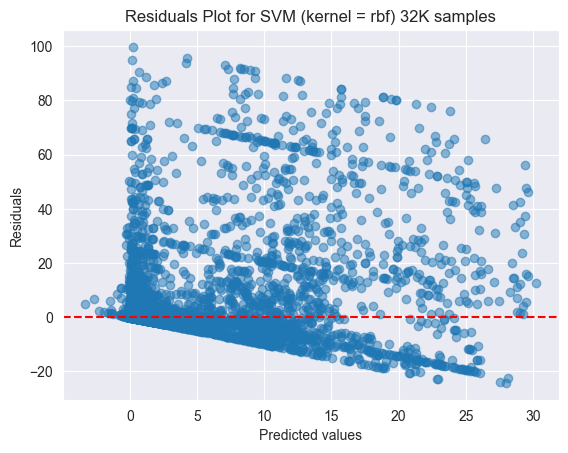

In [155]:
test_model(model_svr_large, X_test_processed_large, y_test_large, "SVM (kernel = rbf) 32K samples")

R2 score for SVM (kernel = rbf) 22K samples: 0.11098580900687649
MAE score for SVM (kernel = rbf) 22K samples: 2.8176882748775105


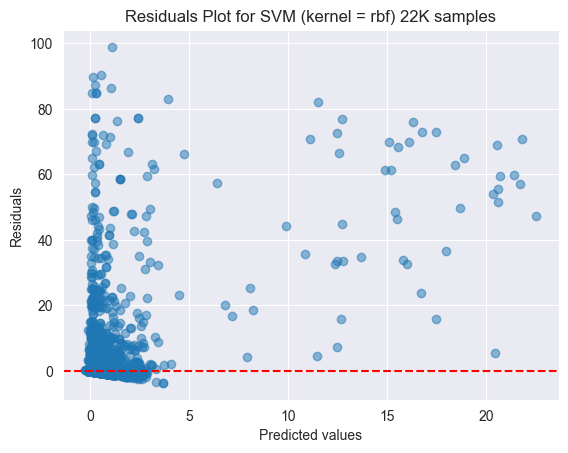

In [156]:
test_model(model_svr_small, X_test_processed_small, y_test_small, "SVM (kernel = rbf) 22K samples")

#### 6.2.2 Polynomial Kernel (degree 2)



In [157]:
model_svr_large = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)
model_svr_large.fit(X_train_processed_large, y_train_large)

model_svr_small = SVR(kernel="poly", degree=2, shrinking=True, tol=0.001)
model_svr_small.fit(X_train_processed_small, y_train_small)

SVR(degree=2, kernel='poly')

R2 score for SVM (kernel = poly, degree 2) 32K samples: 0.1661406040013128
MAE score for SVM (kernel = poly, degree 2) 32K samples: 6.789038779293499


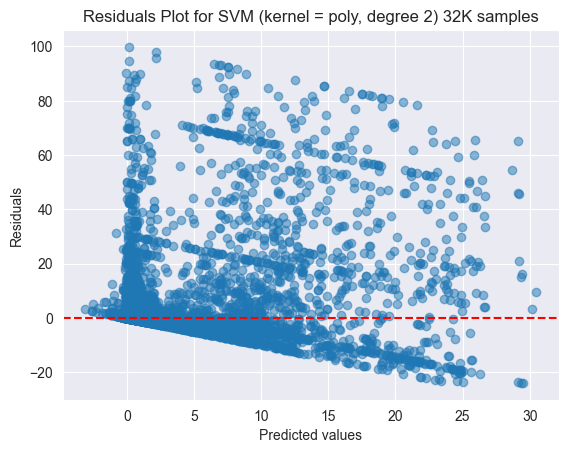

In [158]:
test_model(model_svr_large, X_test_processed_large, y_test_large, "SVM (kernel = poly, degree 2) 32K samples")

R2 score for SMV (kernel = poly, degree 2) 22K samples: 0.13209384904502797
MAE score for SMV (kernel = poly, degree 2) 22K samples: 2.8114514755636724


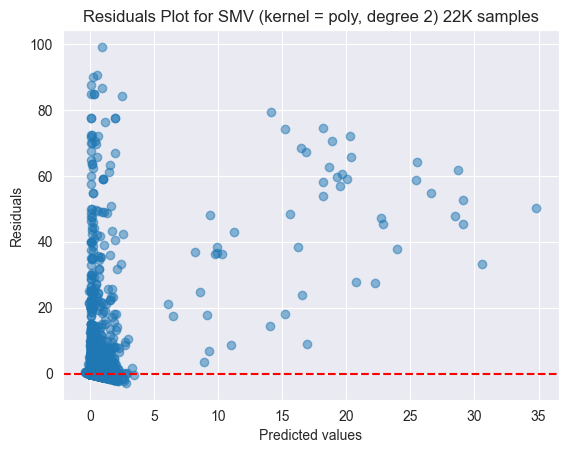

In [159]:
test_model(model_svr_small, X_test_processed_small, y_test_small, "SMV (kernel = poly, degree 2) 22K samples")

#### 6.2.3 Polynomial Kernel (degree 3)

In [160]:
model_svr_large = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)
model_svr_large.fit(X_train_processed_large, y_train_large)

model_svr_small = SVR(kernel="poly", degree=3, shrinking=True, tol=0.001)
model_svr_small.fit(X_train_processed_small, y_train_small)

SVR(kernel='poly')

R2 score for SVM (kernel = poly, degree = 3) 32K samples: 0.21136927851641085
MAE score for SVM (kernel = poly, degree = 3) 32K samples: 6.5929259883552005


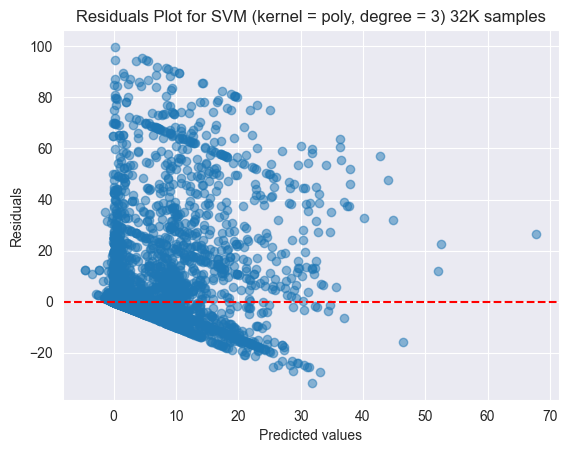

In [161]:
test_model(model_svr_large, X_test_processed_large, y_test_large, "SVM (kernel = poly, degree = 3) 32K samples")

R2 score for SVM (kernel = poly, degree = 3) 22K samples: 0.1672835546695467
MAE score for SVM (kernel = poly, degree = 3) 22K samples: 2.7677602093854126


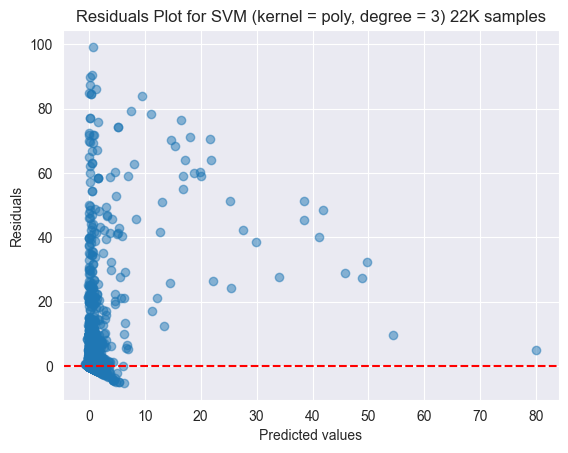

In [162]:
test_model(model_svr_small, X_test_processed_small, y_test_small, "SVM (kernel = poly, degree = 3) 22K samples")

### 6.3 SVM Results Comparison

 SVMs showed persistent scalability limitations when applied to our dataset. Training non-linear kernels was computationally expensive, making large-scale tuning impractical.

Additionally, SVMs are sensitive to multicollinearity, which can distort the margin geometry and lead to unstable predictions. For this reason, only some experiments were selected for SVMs.




## 7. Ensemble Tree Models

A feature importance analysis was conducted using a Decision Tree Regressor to quantify the contribution of each predictor to the model’s performance. Importance scores were aggregated at the base-feature level to account for one-hot encoded categorical variables, and features exceeding a predefined importance threshold were selected as the most influential predictors


In [172]:
def get_base_feature(feature_name):
    for col in num_cols + cat_cols :
        if feature_name.startswith(col):
            return col
    #just take the first part
    return feature_name.split("_")[0]

def tree_feature_importance(X, y, processed_feature_names, threshold=0.03):
    model = DecisionTreeRegressor()
    model.fit(X, y)

    # Feature importance
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        "feature": processed_feature_names,
        "importance": importance
    }).sort_values("importance", ascending=False)


    importance_df["base_feature"] = importance_df["feature"].apply(get_base_feature)

    grouped_importance = (
        importance_df
        .groupby("base_feature")["importance"]
        .sum()
        .sort_values(ascending=False)
    )

    selected_features_tree = [
        f for f, s in zip(grouped_importance.index, grouped_importance.values)
        if s > threshold
    ]
    print(f"Selected features for trees: {selected_features_tree}")
    print(grouped_importance)
    return selected_features_tree


selected_features_tree_large = tree_feature_importance(X_processed_large, y_large, processed_feature_names_large)

selected_features_tree_small = tree_feature_importance(X_processed_small, y_small, processed_feature_names_small)

Selected features for trees: ['Bleaching_Level', 'Temperature_Mean', 'TSA', 'Depth_m', 'Distance_to_Shore', 'ClimSST', 'SSTA', 'Realm_Name', 'Country_Name', 'Cyclone_Frequency', 'Turbidity']
base_feature
Bleaching_Level       0.20674
Temperature_Mean      0.13647
TSA                   0.11308
Depth_m               0.10611
Distance_to_Shore     0.08243
ClimSST               0.06897
SSTA                  0.06200
Realm_Name            0.05935
Country_Name          0.05228
Cyclone_Frequency     0.05121
Turbidity             0.04189
Exposure              0.01802
Ocean_Name            0.00145
Temperature_Maximum   0.00000
Name: importance, dtype: float64
Selected features for trees: ['Bleaching_Level', 'TSA', 'Depth_m', 'ClimSST', 'SSTA', 'Distance_to_Shore', 'Country_Name', 'Cyclone_Frequency', 'Temperature_Mean', 'Turbidity']
base_feature
Bleaching_Level       0.25802
TSA                   0.13484
Depth_m               0.10300
ClimSST               0.10125
SSTA                  0.09334
Dis

### 8.1 Model Selection

Random Forest and XGBoost were selected as advanced ensemble learning methods to evaluate their capacity to model complex, non-linear relationships within the dataset. Both methods provide robust predictive performance, strong generalization, and built-in mechanisms to handle feature interactions, making them well-suited for heterogeneous environmental datasets. Their ability to capture non-linear patterns without extensive feature engineering motivated their use after simpler baseline models demonstrated limited effectiveness.




### 8.2 Initial Ensemble Training

In [173]:
X_processed_large, y_large, X_train_processed_large, X_test_processed_large, y_train_large, y_test_large, processed_feature_names_large = get_preprocessed_split_data(df_normalized_large[selected_features_tree_large])

X_processed_small, y_small,X_train_processed_small, X_test_processed_small, y_train_small, y_test_small, processed_feature_names_small = get_preprocessed_split_data(df_normalized_small)

KeyError: "['Percent_Bleaching'] not found in axis"

In [ ]:
xgb_model_large = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.3,
    min_child_weight=1,
    gamma=0, # No need to add penalty since there is enough samples
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
)

xgb_model_large.fit(X_train_processed_large, y_train_large)

### 8.3 Feature Importance Refinement

* Importance-driven feature pruning
* Retraining with selected features

### 8.4 Hyperparameter Refinement


### 8.5 Ensemble Results

* Final metrics
* Feature importance visualization

## 9. Deep Neural Networks (DNN)

### 9.1 Motivation for DNN

* Non-linearity handling
* High-dimensional interactions

### 9.2 Data Scaling for DNN

```python
# Scaling for neural networks
```

### 9.3 Model Architecture

* Number of layers
* Activation functions
* Regularization methods

```python
# DNN architecture
```

### 9.4 Training & Optimization

* Loss function
* Optimizer
* Early stopping

### 9.5 DNN Performance

* Training vs validation curves
* Final evaluation metrics

---

## 10. Model Comparison

### 10.1 Performance Summary

| Model | Metric 1 | Metric 2 | Notes |
| ----- | -------- | -------- | ----- |

### 10.2 Trade-Off Analysis

* Performance vs complexity
* Training time
* Interpretability

---

## 11. Final Model Selection

* Selected model
* Justification
* Strengths and weaknesses

---

## 12. Conclusions & Future Work

### 12.1 Key Findings

* Data insights
* Model behavior

### 12.2 Limitations

* Data constraints
* Modeling assumptions

### 12.3 Future Improvements

* Feature engineering
* More data
* Model tuning

---

## 13. Appendix

### 13.1 Hyperparameters

### 13.2 Additional Plots

### 13.3 Reproducibility Notes
